In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import serial
from math import *

### Create signal

[0.00340895 0.00742026 0.01884629 0.03946715 0.06766408 0.09843337
 0.12477494 0.13998497 0.13998497 0.12477494 0.09843337 0.06766408
 0.03946715 0.01884629 0.00742026 0.00340895]


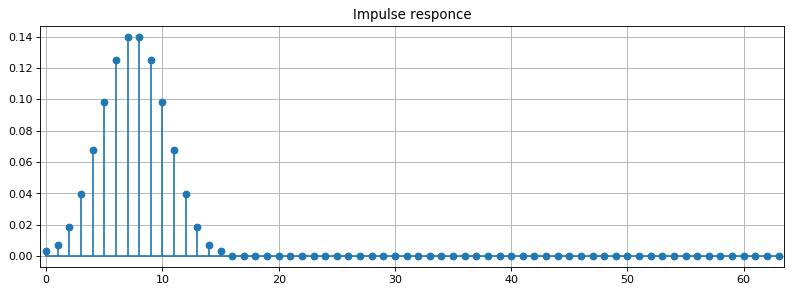

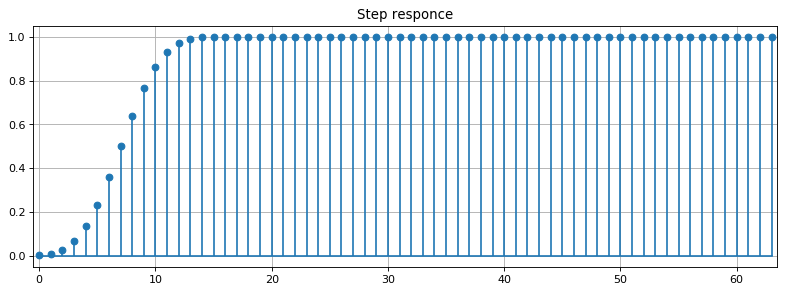

In [2]:
NUM_STAGES = 16
b = signal.firwin(NUM_STAGES, 0.1, window = "hamming")
print(b)

N = 64
imp = np.zeros(N).astype(np.int32)
imp[0] = 1

imp_response = signal.lfilter(b, 1, imp)

plt.figure(figsize=(12, 4), dpi=80)
plt.title('Impulse responce')
plt.stem(imp_response, use_line_collection=True, basefmt='C0')
#plt.plot(imp_response)
plt.xlim([-0.5, N-0.5])
plt.grid(True)

step = np.ones(N).astype(np.int32)
step_response = signal.lfilter(b,1,step)

plt.figure(figsize=(12, 4), dpi=80)
plt.title('Step responce')
plt.stem(step_response, use_line_collection=True, basefmt='C0')
#plt.plot(step_response)
plt.xlim([-0.5, N-0.5])
plt.grid(True)

### Convert coefficients to fixed point and save to file

In [9]:
FW = 30 # floating word length
INPUT_WIDTH = 32 # input width
OUTPUT_WIDTH = 32 # output width

PRODUCT_WIDTH = INPUT_WIDTH * 2
ACC_WIDTH = PRODUCT_WIDTH + ceil(log2(NUM_STAGES))

HEX_LEN = INPUT_WIDTH // 4 if INPUT_WIDTH % 4 == 0 else INPUT_WIDTH // 4 + 1 # hex number length 

b_fix = np.around(b*(2**FW)).astype(np.int64) # convert float to fixed
# convert negative values to two's comp and shrink to INPUT_WIDTH size
b_fix[b_fix < 0] = (b_fix[b_fix < 0] + 2**(INPUT_WIDTH)) & (2**32 - 1) >> (32 - INPUT_WIDTH)

np.savetxt("fir_coefs_b.mem", b_fix, f'%.{HEX_LEN}x')

### Convert signal to fixed point and save to file

In [4]:
sig = imp

sig_fix = np.around(imp*(2**FW)).astype(np.int32)
sig_fix.tofile('./fir_tb_input.bin')

### Get TB output from file

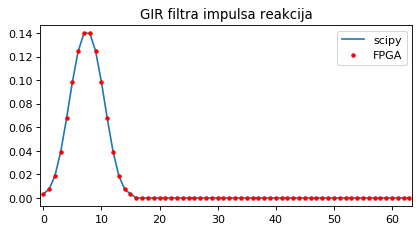

In [5]:
fir_tb_out_fix = np.fromfile('./fir_tb_output.bin', dtype=np.int32)

fir_tb_out = fir_tb_out_fix.copy()
fir_tb_out = fir_tb_out/(2**(FW-6))

plt.figure(figsize=(6, 3), dpi=80)
plt.title('GIR filtra impulsa reakcija')
plt.plot(imp_response)
plt.plot(fir_tb_out, 'r.')
plt.xlim([-0.5, N-0.5])
plt.legend(('scipy', 'FPGA'), loc='best')

plt.savefig('fir_imp.png')

### FPGA serial communication

In [6]:
n_bytes = int(HEX_LEN / 2)
samples = [(i.item()).to_bytes(n_bytes, byteorder='big', signed=True) for i in sig_fix]

fpga_bytes_out = b''
fir_fpga_out_fix = list()

with serial.Serial('/dev/ttyUSB0', 115200, timeout = 2) as ser:
    for i in samples:
        ser.write(i)
        for i in range(4):
            s = ser.read()
            fpga_bytes_out = fpga_bytes_out + s

        fir_fpga_out_fix.append(int.from_bytes(fpga_bytes_out, byteorder='big', signed=True))
        fpga_bytes_out = b''

print("done!")
print(fir_fpga_out_fix)

done!
[57192, 124491, 316188, 662148, 1135214, 1651437, 2093376, 2348558, 2348558, 2093376, 1651437, 1135214, 662148, 316188, 124491, 57192, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Output

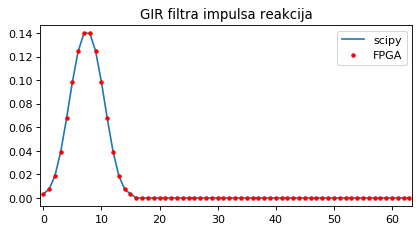

In [7]:
fir_fpga_out_fix = np.array(fir_fpga_out_fix, dtype=np.int32)
fir_fpga_out = fir_fpga_out_fix/(2**(FW-6))

plt.figure(figsize=(6, 3), dpi=80)
plt.title('GIR filtra impulsa reakcija')
plt.plot(imp_response)
plt.plot(fir_fpga_out, 'r.')
plt.legend(('scipy', 'FPGA'), loc='best')
plt.xlim([-0.5, N-0.5])
plt.show()

## Slicing and buffer width calculations

In [8]:
INPUT_WIDTH = 32
INPUT_UPPER_BITS = 8 - INPUT_WIDTH % 8
INPUT_BYTES = INPUT_WIDTH // 8 if INPUT_UPPER_BITS == 8 else INPUT_WIDTH // 8 + 1

print(f"INPUT_WIDTH = {INPUT_WIDTH}")
print(f"INPUT_BYTES = {INPUT_BYTES}")
print(f"INPUT_UPPER_BITS = {INPUT_UPPER_BITS}")
print()

for i in range(INPUT_BYTES):
    msb = 0;
    lsb = 0;
    if (i == 0):
        if (INPUT_UPPER_BITS != 8):
            msb = (INPUT_BYTES * 8) - 1 - INPUT_UPPER_BITS
            lsb = (INPUT_BYTES * 8) - 8
        else:
            msb = (INPUT_BYTES * 8) - 1
            lsb = (INPUT_BYTES * 8) - 8
    else:
        msb = (INPUT_BYTES * 8) - i * 8 - 1
        lsb = (INPUT_BYTES * 8) - (i + 1) * 8
    print(f"[{i}] {msb}:{lsb}")

INPUT_WIDTH = 32
INPUT_BYTES = 4
INPUT_UPPER_BITS = 8

[0] 31:24
[1] 23:16
[2] 15:8
[3] 7:0
